![CRISP-DM](https://raw.githubusercontent.com/zaratsian/Spark/master/nfl_banner2.png)


# Use Case:  Predicting NFL play

### Loading Libraries

In [1]:
import datetime, time 
import re, random, sys
from pyspark.sql.types import StructType, StructField, ArrayType, IntegerType, StringType, FloatType, LongType
from pyspark.sql.functions import struct, array, lit, monotonically_increasing_id, col, expr, when, concat, udf, split, size, lag, count, isnull
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GBTRegressor, LinearRegression, GeneralizedLinearRegression, RandomForestRegressor
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
#sc = SparkContext()
sparkSession = SparkSession(sc).builder.getOrCreate()

# 1. Data Ingestion

### Peeking into data

In [3]:
!curl -i -L "http://edwdemo0.field.hortonworks.com:50070/webhdfs/v1/data/NFLPlaybyPlay2015.csv?op=OPEN" | tail -n 5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.7M  100 14.7M    0     0  59.2M      0 --:--:-- --:--:-- --:--:-- 59.2M
"389412",2016-01-03,"2016010310",22,4,4,"00:43",1,43,7,"GB",42,58,10,12,0,1,"GB","MIN","(:43) (No Huddle, Shotgun) A.Rodgers pass short middle to R.Rodgers to MIN 46 for 12 yards (C.Munnerlyn; A.Sendejo).",1,12,0,0,NA,NA,NA,0,NA,"Pass","A.Rodgers",1,"Complete","Short","middle",0,NA,NA,0,NA,NA,"R.Rodgers",1,NA,NA,NA,"C.Munnerlyn","A.Sendejo",NA,NA,0,NA,NA,0,0,NA,0,NA,NA,NA,0,13,19,-6,6,2015
"391814",2016-01-03,"2016010310",22,4,1,"00:27",1,27,16,"MIN",46,46,10,19,0,0,"GB","MIN","(:27) (No Huddle) A.Rodgers pass short right to D.Adams pushed ob at MIN 39 for 7 yards (T.Newman).",1,7,0,0,NA,NA,NA,0,NA,"Pass","A.Rodgers",1,"Complete","Short","right",0,NA,NA,0,NA,NA,"D.Adams",1,NA

### Load Data from Remote HDP Cluster (from HDFS)

In [4]:
rawdata = sparkSession.read.csv('hdfs://edwdemo0.field.hortonworks.com:8020/data/NFLPlaybyPlay2015.csv', header=True, inferSchema=True)

print '\nTotal Records: ' + str(rawdata.count()) + '\n'
for i in rawdata.dtypes: print i

rawdata = rawdata.select( [rawdata['`'+c+'`'].alias(c.replace('.','_')) for c in rawdata.columns] )


Total Records: 46129

('_c0', 'int')
('Date', 'timestamp')
('GameID', 'int')
('Drive', 'int')
('qtr', 'int')
('down', 'string')
('time', 'string')
('TimeUnder', 'int')
('TimeSecs', 'string')
('PlayTimeDiff', 'string')
('SideofField', 'string')
('yrdln', 'string')
('yrdline100', 'string')
('ydstogo', 'int')
('ydsnet', 'int')
('GoalToGo', 'string')
('FirstDown', 'string')
('posteam', 'string')
('DefensiveTeam', 'string')
('desc', 'string')
('PlayAttempted', 'int')
('Yards.Gained', 'int')
('sp', 'int')
('Touchdown', 'int')
('ExPointResult', 'string')
('TwoPointConv', 'string')
('DefTwoPoint', 'string')
('Safety', 'int')
('PuntResult', 'string')
('PlayType', 'string')
('Passer', 'string')
('PassAttempt', 'int')
('PassOutcome', 'string')
('PassLength', 'string')
('PassLocation', 'string')
('InterceptionThrown', 'int')
('Interceptor', 'string')
('Rusher', 'string')
('RushAttempt', 'int')
('RunLocation', 'string')
('RunGap', 'string')
('Receiver', 'string')
('Reception', 'int')
('ReturnResul

# 2. Data Wrangling: Cleaning , Transformations, Enrichment

## Data Cleaning & Transformations

In [5]:
columns_to_keep =   [   
                    "Date", "GameID", "Drive", "qtr", "down", "time", "TimeUnder", "TimeSecs", 
                    "PlayTimeDiff", "yrdline100", "ydstogo", "ydsnet", "FirstDown", "posteam", 
                    "DefensiveTeam", "Yards_Gained", "Touchdown", "PlayType", "PassLength", 
                    "PassLocation", "RunLocation",
                    #"Passer", "Rusher", "InterceptionThrown", "Season"
                    "PosTeamScore", "DefTeamScore"
                    ]

# Filter columns (keep)
nfldata = rawdata.select(columns_to_keep)

# Drop rows with NAa:
nfldata = nfldata.filter(nfldata.down != 'NA')

# approxQuantile
nfldata.approxQuantile(col='Yards_Gained', probabilities=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], relativeError=0.05)

# Filter target variable (Yards_Gained) to remove outliers
nfldata = nfldata.filter( (col('Yards_Gained') <= 20 ) & (col('Yards_Gained') >= -5 ) )
nfldata.approxQuantile(col='Yards_Gained', probabilities=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], relativeError=0.05)

numeric_columns     = [c[0] for c in nfldata.dtypes if c[1] not in ['string','timestamp']]
categorical_columns = [c[0] for c in nfldata.dtypes if c[1] in ['string']]
datetime_columns    = [c[0] for c in nfldata.dtypes if c[1] in ['timestamp']]

## Data Enrichment & Additional Transformations

In [6]:

nfldata2 = nfldata.withColumn("Date",            col("Date"))                       \
                    .withColumn("GameID",       col("GameID").cast("int"))          \
                    .withColumn("Drive",        col("Drive").cast("int"))           \
                    .withColumn("qtr",          col("qtr").cast("int"))             \
                    .withColumn("down",         col("down").cast("int"))            \
                    .withColumn("time",         col("time").cast("string"))         \
                    .withColumn("TimeUnder",    col("TimeUnder").cast("int"))       \
                    .withColumn("TimeSecs",     col("TimeSecs").cast("int"))        \
                    .withColumn("PlayTimeDiff", col("PlayTimeDiff").cast("int"))    \
                    .withColumn("yrdline100",   col("yrdline100").cast("int"))      \
                    .withColumn("ydstogo",      col("ydstogo").cast("int"))         \
                    .withColumn("ydsnet",       col("ydsnet").cast("int"))          \
                    .withColumn("FirstDown",    col("FirstDown").cast("int"))       \
                    .withColumn("posteam",      col("posteam").cast("string"))      \
                    .withColumn("DefensiveTeam",col("DefensiveTeam").cast("string"))\
                    .withColumn("Yards_Gained", col("Yards_Gained").cast("int"))    \
                    .withColumn("Touchdown",    col("Touchdown").cast("int"))       \
                    .withColumn("PlayType",     col("PlayType").cast("string"))     \
                    .withColumn("PassLength",   col("PassLength").cast("string"))   \
                    .withColumn("PassLocation", col("PassLocation").cast("string")) \
                    .withColumn("RunLocation",  col("RunLocation").cast("string"))  \
                    .withColumn("PosTeamScore", col("PosTeamScore").cast("int"))    \
                    .withColumn("DefTeamScore", col("DefTeamScore").cast("int")) 


numeric_columns     = [c[0] for c in nfldata2.dtypes if c[1] not in ['string','timestamp']]
categorical_columns = [c[0] for c in nfldata2.dtypes if c[1] in ['string']]
datetime_columns    = [c[0] for c in nfldata2.dtypes if c[1] in ['timestamp']]

'''
# Correlation
seen = []
for c1 in numeric_columns:
    for c2 in numeric_columns:
        correlation = round(nfldata2.stat.corr(c1, c2), 8)
        #if (correlation >= 0.90 or correlation <= 0.10) and (c1 != c2) and ((c1,c2) not in seen):
        if (correlation >= 0.70) and (c1 != c2) and ((c1,c2) not in seen):
            seen.append((c2,c1))
            print str(correlation) + '\tCorrelation for ' + str(c1) + ' and ' + str(c2)
'''

# Category Levels
[nfldata2.select(nfldata2[c]).groupBy(nfldata2[c]).count().show(5,False) for c in categorical_columns]

+-----+-----+
|time |count|
+-----+-----+
|03:15|34   |
|02:39|38   |
|07:24|36   |
|06:43|37   |
|04:02|28   |
+-----+-----+
only showing top 5 rows

+-------+-----+
|posteam|count|
+-------+-----+
|NYJ    |1182 |
|CAR    |1146 |
|TB     |1121 |
|OAK    |1113 |
|DET    |1117 |
+-------+-----+
only showing top 5 rows

+-------------+-----+
|DefensiveTeam|count|
+-------------+-----+
|NYJ          |1105 |
|CAR          |1122 |
|TB           |1154 |
|OAK          |1200 |
|DET          |1064 |
+-------------+-----+
only showing top 5 rows

+----------+-----+
|PlayType  |count|
+----------+-----+
|Field Goal|985  |
|Run       |12699|
|No Play   |2463 |
|QB Kneel  |424  |
|Timeout   |2    |
+----------+-----+
only showing top 5 rows

+----------+-----+
|PassLength|count|
+----------+-----+
|NA        |18366|
|Deep      |2755 |
|Short     |14933|
+----------+-----+

+------------+-----+
|PassLocation|count|
+------------+-----+
|NA          |18366|
|left        |6648 |
|middle      |3924 |
|

[None, None, None, None, None, None, None]

## Data Enrichment & Additional Transformations (Continued...)

In [7]:
# Filter - Keep where Playtype in ['Run','Pass'] 
nfldata2 = nfldata2.filter( (nfldata2.PlayType=="Run") | (nfldata2.PlayType=="Pass") )

# Derive Date var(s)
nfldata2 = nfldata2.withColumn("month_day", concat(nfldata2["Date"].substr(6,2), nfldata2["Date"].substr(9,2)).cast("int") )

# Lag (Get previous PlayType)
w = Window().partitionBy('GameID','Drive').orderBy('GameID','Drive', col('TimeSecs').desc())
nfldata2 = nfldata2.withColumn("PlayType_lag", lag("PlayType").over(w) ) \
                 .withColumn("PlayType_lag",  when( isnull('PlayType_lag'), 'FirstPlay').otherwise( col('PlayType_lag') ) ) \
                 .orderBy('GameID','Drive', col('TimeSecs').desc())

# Print Results
#nfldata2.select(["GameID","Drive","qtr","down","TimeSecs","PlayType","PlayType_lag","yrdline100","posteam","month_day"]).show(50,False)

# Split into "Run" and "Pass" (I want to build two models)
nfldata2_run  = nfldata2.filter( col('PlayType')=='Run' )
nfldata2_pass = nfldata2.filter( col('PlayType')=='Pass' )

print "Total Number of Records:   " + str(nfldata2.count())
print "Number of Running Records: " + str(nfldata2_run.count())
print "Number of Passing Records: " + str(nfldata2_pass.count())

Total Number of Records:   29412
Number of Running Records: 12699
Number of Passing Records: 16713


# 3. Data Exploration

In [9]:
# Inspecting RDDs
print(type(nfldata2))

<class 'pyspark.sql.dataframe.DataFrame'>


In [10]:
# generating pandas dataframe for visualizations
run_pd = nfldata2_run.toPandas()

In [11]:
pass_pd= nfldata2_pass.toPandas()

In [12]:
# viewing the run data
run_pd.head(5)

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0 2015-09-10  2015091000      1    1     1  15:00         15      3600   
1 2015-09-10  2015091000      1    1     2  14:04         15      3544   
2 2015-09-10  2015091000      1    1     1  12:42         13      3462   
3 2015-09-10  2015091000      1    1     2  10:53         11      3353   
4 2015-09-10  2015091000      3    1     1  07:41          8      3161   

   PlayTimeDiff  yrdline100     ...       Yards_Gained  Touchdown  PlayType  \
0             0          80     ...                 18          0       Run   
1            17          53     ...                  4          0       Run   
2            44          35     ...                 11          0       Run   
3            27          42     ...                  6          0       Run   
4             7          93     ...                  6          0       Run   

  PassLength PassLocation  RunLocation  PosTeamScore DefTeamScore month_day  \
0         NA           NA        right             0            0       910   
1         NA           NA        right             0            0       910   
2         NA           NA        right             0            0       910   
3         NA           NA        right             0            0       910   
4         NA           NA         left             0            0       910   

  PlayType_lag  
0    FirstPlay  
1         Pass  
2         Pass  
3          Run  
4    FirstPlay  

[5 rows x 25 columns]

In [13]:
# viewing the pass data
pass_pd.head(5)

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0 2015-09-10  2015091000      1    1     1  14:21         15      3561   
1 2015-09-10  2015091000      1    1     1  13:26         14      3506   
2 2015-09-10  2015091000      1    1     3  10:28         11      3328   
3 2015-09-10  2015091000      2    1     1  09:40         10      3280   
4 2015-09-10  2015091000      2    1     1  09:14         10      3254   

   PlayTimeDiff  yrdline100     ...       Yards_Gained  Touchdown  PlayType  \
0            39          62     ...                  9          0      Pass   
1            38          49     ...                 14          0      Pass   
2            25          36     ...                 10          0      Pass   
3             4          66     ...                 13          0      Pass   
4            26          68     ...                 12          0      Pass   

  PassLength PassLocation  RunLocation  PosTeamScore DefTeamScore month_day  \
0      Short        right           NA             0            0       910   
1      Short        right           NA             0            0       910   
2      Short        right           NA             0            0       910   
3      Short         left           NA             0            0       910   
4      Short         left           NA             0            0       910   

  PlayType_lag  
0          Run  
1          Run  
2          Run  
3    FirstPlay  
4         Pass  

[5 rows x 25 columns]

In [14]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# set plot size
fig_size=[0,0]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# setting style
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

### Correlation Matrix for features

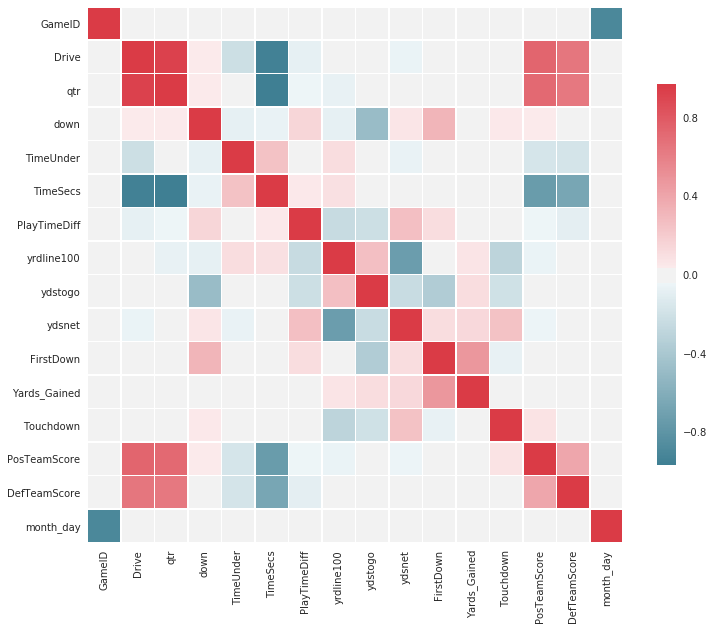

In [15]:
# Compute the correlation matrix
corr = run_pd.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Visualizing multidimensional relationships

*exploring correlations between multidimensional data, when you'd like to plot all pairs of values against each other.*

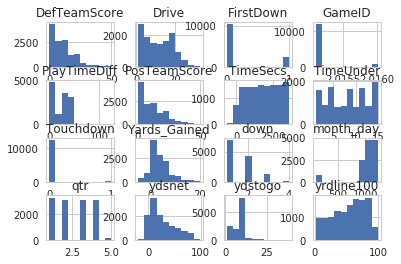

In [16]:
# histograms
run_pd.hist()
plt.show()

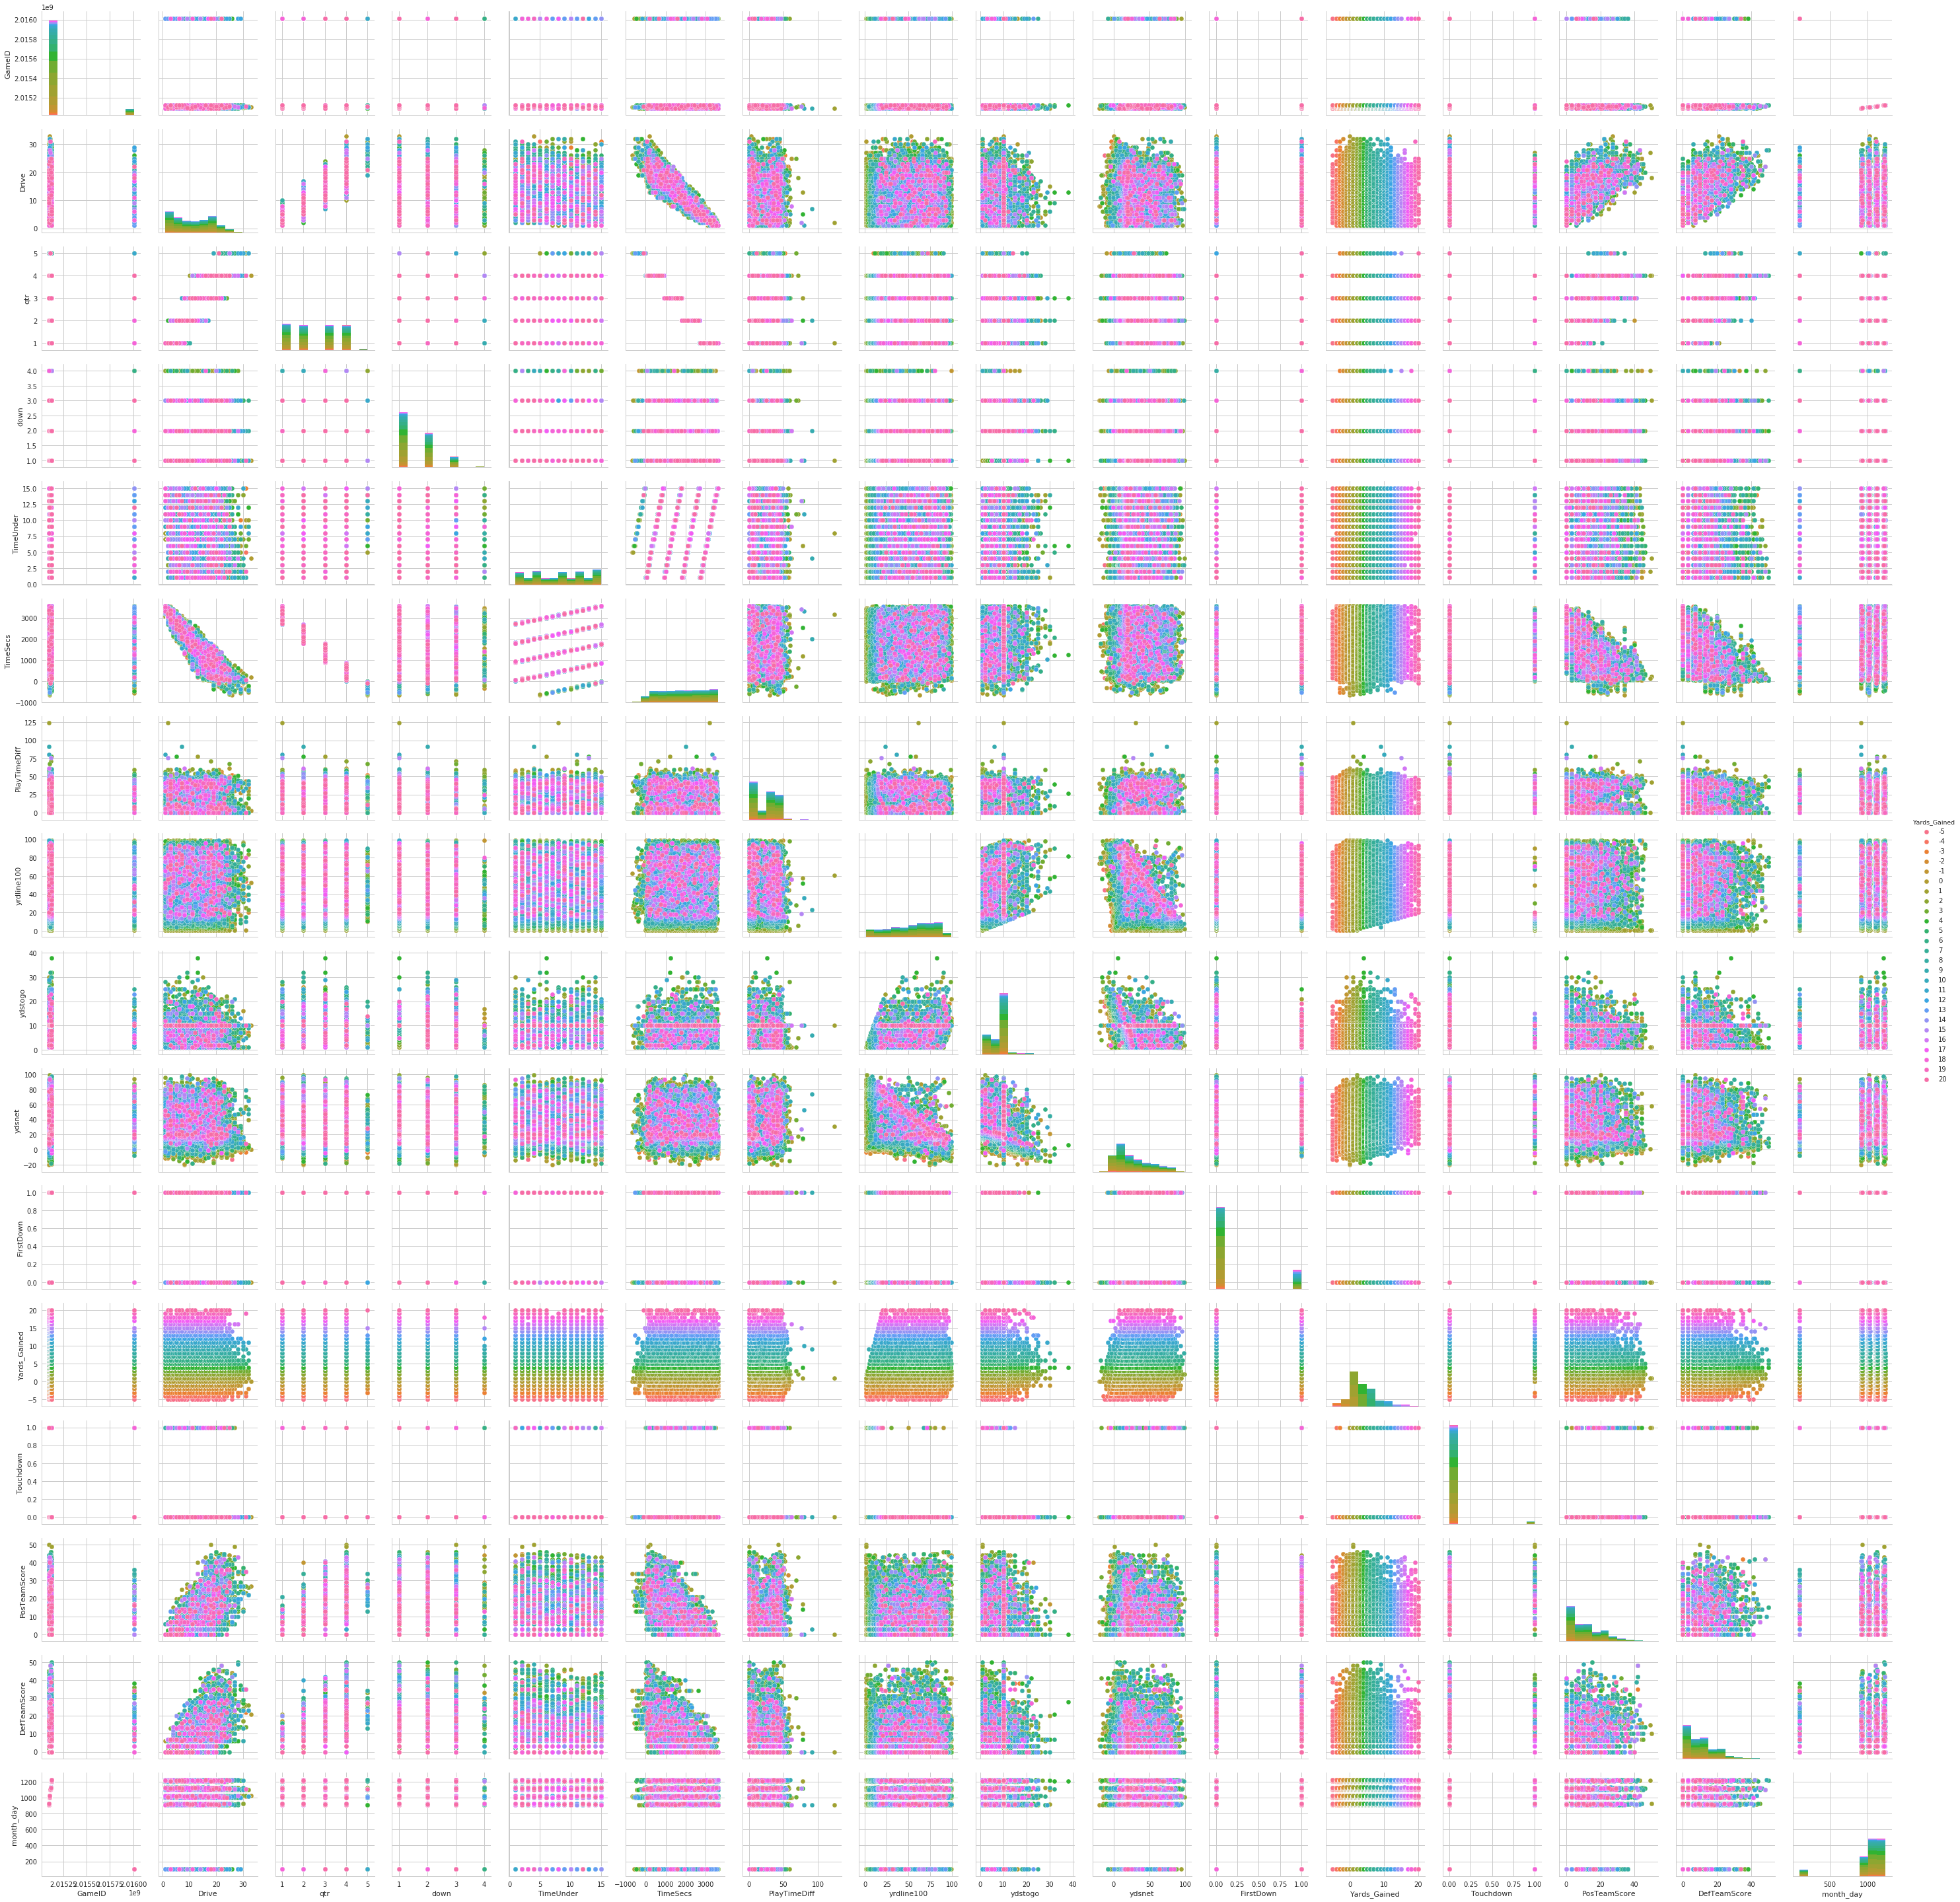

In [17]:
# pair plot
sns.pairplot(run_pd, hue='Yards_Gained', size=2.5);
plt.show() 

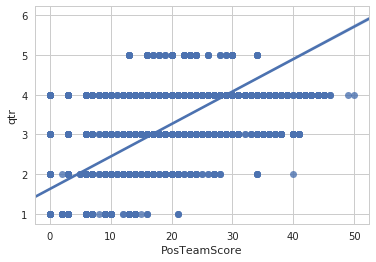

In [18]:
# Linear Regression Plot
lm=sns.regplot(x="PosTeamScore", y="qtr", data=run_pd)
plt.show()

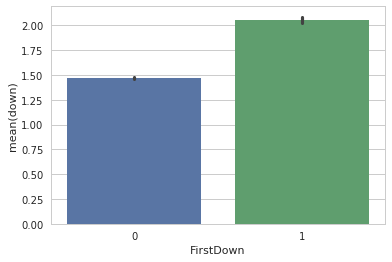

In [19]:
# bar charts
sns.barplot(y="down", x="FirstDown", data=run_pd)

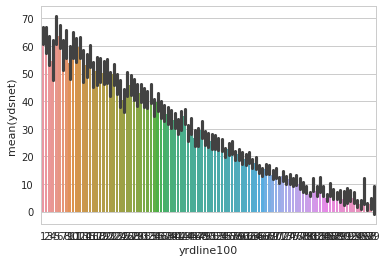

In [20]:
# bar chart 3 features
ax = sns.barplot(x="yrdline100", y="ydsnet", data=run_pd)

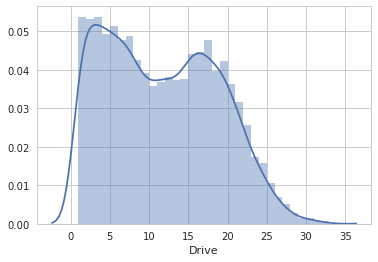

In [21]:
# distribution plot
sns.distplot(run_pd["Drive"]);

# Model Building

### Split into Train and Test

In [8]:
training_run, testing_run   = nfldata2_run.randomSplit([0.8, 0.2], seed=12345)
training_pass, testing_pass = nfldata2_pass.randomSplit([0.8, 0.2], seed=12345)

### Building Model Pipeline

In [9]:
# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
si1 = StringIndexer(inputCol="PlayType", outputCol="PlayType_index")
si2 = StringIndexer(inputCol="PlayType_lag", outputCol="PlayType_lag_index")
si3 = StringIndexer(inputCol="PassLength", outputCol="PassLength_index")
si4 = StringIndexer(inputCol="PassLocation", outputCol="PassLocation_index")
si5 = StringIndexer(inputCol="RunLocation", outputCol="RunLocation_index")

target   = 'Yards_Gained'
features = ['qtr','down','TimeSecs','yrdline100','ydstogo','ydsnet','month_day','PlayType_lag_index']

#encode the Label column: feature indexer
fi = StringIndexer(inputCol='Yards_Gained', outputCol='label').fit(training_run)

# Pipelines API requires that input variables are passed in  a vector
va  = VectorAssembler(inputCols=features, outputCol="features")

In [10]:
# run the algorithm and build model taking the default settings
rfr = RandomForestRegressor(featuresCol="label", labelCol=target, predictionCol="prediction", maxDepth=5, maxBins=350, seed=12345)
gbr = GBTRegressor(featuresCol="features", labelCol=target, predictionCol="prediction", maxDepth=5, maxBins=350, seed=12345)

# Convert indexed labels back to original labels, label converter
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=fi.labels)

### Training the Model

In [11]:
# Build the machine learning pipeline
pipeline_run  = Pipeline(stages=[si2, fi, va, gbr, labelConverter])

# Build model. 
# The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages.
model_run = pipeline_run.fit(training_run)

# store the predictions on training data on HDFS
#model_run.write().overwrite().save('hdfs://dzaratsian0.field.hortonworks.com:8020/models/nfl_model_run3')

#print(model_run.bestModel.stages[-2].featureImportances)

### Making predictions for model

In [43]:
# Make predictions.
predictions = model_run.transform(testing_run)
# show the results
predictions.show(3)

+--------------------+----------+-----+---+----+-----+---------+--------+------------+----------+-------+------+---------+-------+-------------+------------+---------+--------+----------+------------+-----------+------------+------------+---------+------------+------------------+-----+--------------------+------------------+--------------+
|                Date|    GameID|Drive|qtr|down| time|TimeUnder|TimeSecs|PlayTimeDiff|yrdline100|ydstogo|ydsnet|FirstDown|posteam|DefensiveTeam|Yards_Gained|Touchdown|PlayType|PassLength|PassLocation|RunLocation|PosTeamScore|DefTeamScore|month_day|PlayType_lag|PlayType_lag_index|label|            features|        prediction|predictedLabel|
+--------------------+----------+-----+---+----+-----+---------+--------+------------+----------+-------+------+---------+-------+-------------+------------+---------+--------+----------+------------+-----------+------------+------------+---------+------------+------------------+-----+--------------------+---------

### Generate results of classifier

In [46]:
predictions=predictions.select(predictions["Yards_Gained"],predictions["predictedLabel"],predictions["prediction"])
type(predictions)


pyspark.sql.dataframe.DataFrame

In [47]:
predictions.show(5)

+------------+--------------------+--------------+------------------+
|Yards_Gained|            features|predictedLabel|        prediction|
+------------+--------------------+--------------+------------------+
|           6|[1.0,1.0,3161.0,9...|             5| 5.382240411575233|
|           1|[1.0,2.0,2860.0,8...|             1| 2.902966596624522|
|           1|[1.0,3.0,2825.0,8...|             3|1.3161763746859476|
|           8|[2.0,1.0,2182.0,2...|             4|3.4124100345484907|
|           0|[2.0,1.0,2286.0,5...|             3|1.3747241089765352|
+------------+--------------------+--------------+------------------+
only showing top 5 rows



### Model Evaluation

In [48]:
# Evaluate Results
evaluator = RegressionEvaluator(metricName="rmse", labelCol=target)  # rmse (default)|mse|r2|mae
RMSE = evaluator.evaluate(predictions)
print 'RMSE: ' + str(RMSE)

evaluator = RegressionEvaluator(metricName="mae", labelCol=target)  # rmse (default)|mse|r2|mae
MAE = evaluator.evaluate(predictions) # Mean Absolute Error
print 'MSE: ' + str(MAE)

RMSE: 3.20436957856
MSE: 2.11528652214


# Model Management: Save & Deploy

In [12]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

In [13]:
service_path = 'https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443'
ml_repository_client = MLRepositoryClient()

In [52]:
type(model_run)

pyspark.ml.pipeline.PipelineModel

### Create model artifact (abstraction layer)

In [14]:
model_artifact = MLRepositoryArtifact(model_run, training_data=training_run, name="NFL_Predict_Run_Play")

### Save pipeline and model artifacts to in Machine Learning repository

In [ ]:
saved_model = ml_repository_client.models.save(model_artifact)

### Saved model properties

In [55]:
print "modelType: " + saved_model.meta.prop("modelType")
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")

modelType: sparkml-model-2.0
creationTime: 2017-10-31 14:25:43.306000+00:00
modelVersionHref: https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443/v2/artifacts/models/953e1251-02d5-4f2f-a5a2-feab21ec9996/versions/13f2e6f8-8dc2-4ae6-b881-f2f01beee647
label: Yards_Gained


In [66]:
tr=training_run.toPandas()

In [71]:
list(tr.columns)

['Date',
 'GameID',
 'Drive',
 'qtr',
 'down',
 'time',
 'TimeUnder',
 'TimeSecs',
 'PlayTimeDiff',
 'yrdline100',
 'ydstogo',
 'ydsnet',
 'FirstDown',
 'posteam',
 'DefensiveTeam',
 'Yards_Gained',
 'Touchdown',
 'PlayType',
 'PassLength',
 'PassLocation',
 'RunLocation',
 'PosTeamScore',
 'DefTeamScore',
 'month_day',
 'PlayType_lag']

In [68]:
# values for input
for i in tr.columns:
    print(i, run_pd[i][10])
'2015-09-10 00:00:00', 2015091000, 4, 2, 1,'14:30', 15, 2670, 30, 63, 10, 24, 0, 'NE', 'PIT', -3, 0, 'Run', 'NA', 'NA', 'left', 0, 0, 910, 'Run'



('Date', Timestamp('2015-09-10 00:00:00'))
('GameID', 2015091000)
('Drive', 4)
('qtr', 2)
('down', 1)
('time', u'14:30')
('TimeUnder', 15)
('TimeSecs', 2670)
('PlayTimeDiff', 30)
('yrdline100', 63)
('ydstogo', 10)
('ydsnet', 24)
('FirstDown', 0)
('posteam', u'NE')
('DefensiveTeam', u'PIT')
('Yards_Gained', -3)
('Touchdown', 0)
('PlayType', u'Run')
('PassLength', u'NA')
('PassLocation', u'NA')
('RunLocation', u'left')
('PosTeamScore', 0)
('DefTeamScore', 0)
('month_day', 910)
('PlayType_lag', u'Run')


# Model Testing: UI & API 

## UI Testing

## API Testing

### Retreiving  bearer token 

In [73]:
!curl -k -X GET https://172.26.222.224/v2/identity/token -H "username: dzaratsian" -H "password: BadPass#1"

{"_messageCode_":"signin_fail","message":"Sorry, we could not verify your username and password.","_statusCode_":401}

### Invoke model remotely

!curl -i -k -X POST https://172.26.228.121/v2/scoring/online/4a5692ff-2bfc-42d4-a005-ebbd8ffea88a -d '{"fields": ["isCertified","paymentScheme","hoursDriven","milesDriven","latitude","longitude","isFoggy","isRainy","isWindy"], "records": [["N","miles",0.000000,0.000000,-94.590000,39.100000,0.000000,0.000000,0.000000]]}' -H "content-type: application/json" -H "authorization: Bearer <token>"

In [ ]:
!curl -i -k -X POST https://172.26.228.121/v2/scoring/online/2304b6e2-51aa-4e57-821d-35b565caf8cf -d '{"fields":['Date', 'GameID', 'Drive','qtr','down','time','TimeUnder','TimeSecs','PlayTimeDiff','yrdline100', 'ydstogo', 'ydsnet', 'FirstDown', 'posteam', 'DefensiveTeam', 'Yards_Gained','Touchdown','PlayType', 'PassLength', 'PassLocation', 'RunLocation', 'PosTeamScore', 'DefTeamScore', 'month_day', 'PlayType_lag']},"records":[['2015-09-10 00:00:00', 2015091000, 4, 2, 1,'14:30', 15, 2670, 30, 63, 10, 24, 0, 'NE', 'PIT', -3, 0, 'Run', 'NA', 'NA', 'left', 0, 0, 910, 'Run']]'
    
    
    